In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd


In [2]:
#Load oligo array from 2019

import isolearn.io as isoio

isoform_pseudo_count = 1.
proximal_start = 77
proximal_end = 127

file_prefix = str(proximal_start) + "_" + str(proximal_end)

seq_dict = isoio.load('../../../../aparent/data/prepared_data/apa_array_data/apa_array_data_seq')

#Load predictions (Resnet)
model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'
pred_dict = isoio.load('../../../analysis/predictions/apa_array_data_legacy/' + model_name + '_predictions_seq')


In [3]:

print("n (sequences) = " + str(len(seq_dict['array_df'])))


n (sequences) = 186066


In [4]:

seq_df = seq_dict['array_df']
seq_cuts = seq_dict['pooled_cuts']

pred_df = pred_dict['array_df']
cuts_pred = pred_dict['cut_prob']

seq_df['row_index_true'] = np.arange(len(seq_df), dtype=np.int)
pred_df['row_index_pred'] = np.arange(len(pred_df), dtype=np.int)

seq_df = seq_df.join(pred_df[['seq', 'row_index_pred']].set_index('seq'), on='seq', how='inner').copy().reset_index(drop=True)

seq_cuts = seq_cuts[np.ravel(seq_df['row_index_true'].values), :]
cut_true = np.concatenate([np.array(seq_cuts[:, 180: 180 + 205].todense()), np.array(seq_cuts[:, -1].todense()).reshape(-1, 1)], axis=-1)# - 1

seq_df['proximal_count'] = [np.sum(cut_true[i, proximal_start:proximal_end]) for i in range(len(seq_df))]
seq_df['proximal_count_0_205'] = [np.sum(cut_true[i, 0:205]) for i in range(len(seq_df))]
seq_df['total_count'] = [np.sum(cut_true[i, :]) for i in range(len(seq_df))]

seq_df['iso_true'] = (seq_df['proximal_count'] + isoform_pseudo_count) / (seq_df['total_count'] + 2. * isoform_pseudo_count)
seq_df['iso_true_0_205'] = (seq_df['proximal_count_0_205'] + isoform_pseudo_count) / (seq_df['total_count'] + 2. * isoform_pseudo_count)
seq_df['logodds_true'] = np.log(seq_df['iso_true'] / (1.0 - seq_df['iso_true']))
seq_df['logodds_true_0_205'] = np.log(seq_df['iso_true_0_205'] / (1.0 - seq_df['iso_true_0_205']))

cut_pred = np.array(cuts_pred[np.ravel(seq_df['row_index_pred'].values), :].todense())

seq_df['iso_pred'] = [np.clip(np.sum(cut_pred[i, proximal_start:proximal_end]), 1e-6, 1. - 1e-6) for i in range(len(seq_df))]
seq_df['iso_pred_0_205'] = [np.clip(np.sum(cut_pred[i, 0:205]), 1e-6, 1. - 1e-6) for i in range(len(seq_df))]
seq_df['logodds_pred'] = np.log(seq_df['iso_pred'] / (1.0 - seq_df['iso_pred']))
seq_df['logodds_pred_0_205'] = np.log(seq_df['iso_pred_0_205'] / (1.0 - seq_df['iso_pred_0_205']))


In [5]:
#Filter on native/human wt sequences with high quality (no long a-runs)

print("n (pre-filtering) = " + str(len(seq_df)))

seq_df = seq_df.query("n_barcodes >= 2 and mean_total_count >= 200 and gene != 'Missing' and variant == 'wt' and significance == 'Missing'").copy().reset_index(drop=True)
seq_df = seq_df.loc[seq_df['experiment'].isin([
    'sensitive_genes',
    'acmg_apadb',
    'human variant',
    'clinvar_mut',
    'acmg_polyadb',
    'clinvar_wt'
])].copy().reset_index(drop=True)

seq_df = seq_df.loc[~seq_df['seq'].str.contains("AAAAAAAAA|AAAAGAAAA|AAAACAAAA|AAAATAAAA")].copy().reset_index(drop=True)
seq_df = seq_df.sort_values(by=['total_count'], ascending=False).copy().reset_index(drop=True)

seq_df = seq_df.drop_duplicates(subset=['gene'], keep='first')
seq_df = seq_df.sort_values(by=['gene'], ascending=True).copy().reset_index(drop=True)

print("n (post-filtering) = " + str(len(seq_df)))


n (pre-filtering) = 186066
n (post-filtering) = 1371


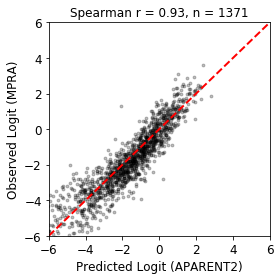

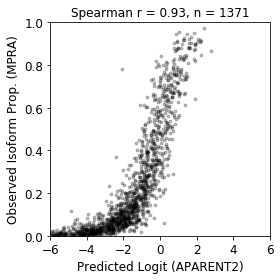

In [6]:
from scipy.stats import spearmanr, pearsonr

r_val = spearmanr(seq_df['logodds_pred'], seq_df['logodds_true'])[0]

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred'], seq_df['logodds_true'], color='black', s=8, alpha=0.25)

plt.plot([-6., 6.], [-6. ,6.], linewidth=2, linestyle='--', color='red')

plt.xlim(-6., 6.)
plt.ylim(-6., 6.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (APARENT2)", fontsize=12)
plt.ylabel("Observed Logit (MPRA)", fontsize=12)

plt.title("Spearman r = " + str(round(r_val, 3)) + ", n = " + str(len(seq_df)))

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred'], seq_df['iso_true'], color='black', s=8, alpha=0.25)

plt.xlim(-6., 6.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (APARENT2)", fontsize=12)
plt.ylabel("Observed Isoform Prop. (MPRA)", fontsize=12)

plt.title("Spearman r = " + str(round(r_val, 3)) + ", n = " + str(len(seq_df)))

plt.tight_layout()

plt.show()


In [7]:
#Remove outlier predictions

q = 0.1

seq_df['se'] = (seq_df['logodds_pred'] - seq_df['logodds_true'])**2

seq_df = seq_df.sort_values(by='se', ascending=True)[:-int(q * len(seq_df))].copy().reset_index(drop=True)


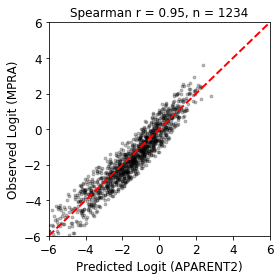

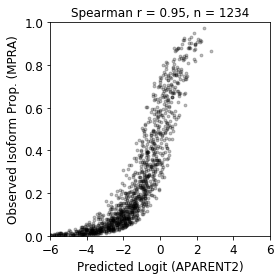

In [8]:
from scipy.stats import spearmanr, pearsonr

r_val = spearmanr(seq_df['logodds_pred'], seq_df['logodds_true'])[0]

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred'], seq_df['logodds_true'], color='black', s=8, alpha=0.25)

plt.plot([-6., 6.], [-6. ,6.], linewidth=2, linestyle='--', color='red')

plt.xlim(-6., 6.)
plt.ylim(-6., 6.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (APARENT2)", fontsize=12)
plt.ylabel("Observed Logit (MPRA)", fontsize=12)

plt.title("Spearman r = " + str(round(r_val, 3)) + ", n = " + str(len(seq_df)))

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred'], seq_df['iso_true'], color='black', s=8, alpha=0.25)

plt.xlim(-6., 6.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (APARENT2)", fontsize=12)
plt.ylabel("Observed Isoform Prop. (MPRA)", fontsize=12)

plt.title("Spearman r = " + str(round(r_val, 3)) + ", n = " + str(len(seq_df)))

plt.tight_layout()

plt.show()


In [9]:
#Select controls

rand_logit = 0.05

target_logits = [-5., -3., -1., 0., 1., 3.]

seq_df = seq_df.sort_values(by='logodds_true', ascending=True).copy().reset_index(drop=True)

control_index = []

for target_logit in target_logits :
    rand_vec = np.random.uniform(low=-rand_logit, high=rand_logit, size=(len(seq_df,)))
    obj_vec = (target_logit + rand_vec - np.array(seq_df['logodds_true'].values))**2
    
    control_index.append(np.argsort(obj_vec)[0])

control_df = seq_df.iloc[control_index].copy().reset_index(drop=True)


In [10]:
#Overload with previously chosen controls

control_df = seq_df.loc[seq_df['gene'].isin([
    "CYP4F22.1",
    "BBS2.3",
    "CANT1.3",
    "COL4A4.1",
    "RYR2.1",
    "RB1.11",
])].copy().reset_index(drop=True)


In [11]:

control_df['seq'].str.slice(70)


0    CATAAACTCAGATTTTGGGGGTCAGTTTGTGTGTTCATTTATTTCA...
1    TATAAATACATATTTTTTTCTTGAAATTGCAATTGAGTTTGTACTT...
2    AATAAAGCGTCTGAGGGAGTGTAGTTTTCTGTCTCCCGGTCTGTGC...
3    TATAAAATTCTGTGATGACTTCCAAAAACAACTGTGTTTTATCTGG...
4    AATAAATGATGGTCTGTTATAATAAGTAACTACTCTGTCACTTATT...
5    AATAAACACTTTTGTTCAATTTAAAGTTAAAATGTGGTGTGTTTCT...
Name: seq, dtype: object

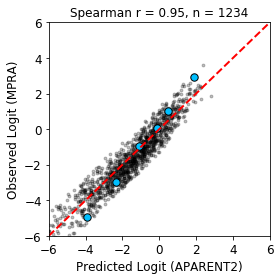

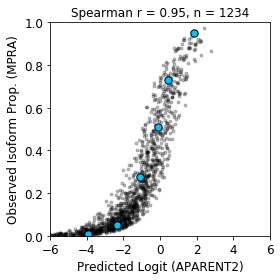

In [12]:
from scipy.stats import spearmanr, pearsonr

r_val = spearmanr(seq_df['logodds_pred'], seq_df['logodds_true'])[0]

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred'], seq_df['logodds_true'], color='black', s=8, alpha=0.25)
plt.scatter(control_df['logodds_pred'], control_df['logodds_true'], color='deepskyblue', linewidth=1, edgecolor='black', s=55, alpha=1.)

plt.plot([-6., 6.], [-6. ,6.], linewidth=2, linestyle='--', color='red')

plt.xlim(-6., 6.)
plt.ylim(-6., 6.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (APARENT2)", fontsize=12)
plt.ylabel("Observed Logit (MPRA)", fontsize=12)

plt.title("Spearman r = " + str(round(r_val, 3)) + ", n = " + str(len(seq_df)))

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(4, 4))

plt.scatter(seq_df['logodds_pred'], seq_df['iso_true'], color='black', s=8, alpha=0.25)
plt.scatter(control_df['logodds_pred'], control_df['iso_true'], color='deepskyblue', linewidth=1, edgecolor='black', s=55, alpha=1.)

plt.xlim(-6., 6.)
plt.ylim(0., 1.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Logit (APARENT2)", fontsize=12)
plt.ylabel("Observed Isoform Prop. (MPRA)", fontsize=12)

plt.title("Spearman r = " + str(round(r_val, 3)) + ", n = " + str(len(seq_df)))

plt.tight_layout()

plt.show()


In [13]:
#Compile control sequence library

library_df = control_df.copy()

library_df['ref_seq'] = library_df['seq']
library_df['var_seq'] = library_df['seq']

#Set data source and experiment
library_df['data_source'] = 'Array_2019'
library_df['experiment'] = 'control_' + library_df['gene']
library_df['snp_id'] = 'Missing'

library_df['gene_id'] = library_df['gene']
library_df['gene'] = library_df['gene'].apply(lambda x: x.split(".")[0])

library_df['ref_logit_pred_77_127'] = np.round(library_df['logodds_pred'], 4)
library_df['var_logit_pred_77_127'] = np.round(library_df['logodds_pred'], 4)

library_df['ref_logit_pred_0_205'] = np.round(library_df['logodds_pred_0_205'], 4)
library_df['var_logit_pred_0_205'] = np.round(library_df['logodds_pred_0_205'], 4)

library_df['delta_logodds_77_127'] = 0.0
library_df['delta_logodds_0_205'] = 0.0

library_df['chrom'] = "Missing"
library_df['strand'] = "Missing"

library_df['pas_pos'] = -1
library_df['pas_pos_hg38'] = -1
library_df['var_position'] = -1
library_df['var_position_hg38'] = -1
library_df['ref_nucleotide'] = -1
library_df['var_nucleotide'] = -1
library_df['rel_var_position'] = -1

#Slice sequences and add downstream conserved region
upstream_homology = "TCCCTACACGACGCTCTTCCGATCT"
downstream_homology = "GGAGCAGATACTGGCTTAACTATGC"

library_df['ref_seq'] = library_df['ref_seq'].str.slice(0, 20+164) + downstream_homology
library_df['var_seq'] = library_df['var_seq'].str.slice(0, 20+164) + downstream_homology

library_df['ref_seq_w_homology'] = upstream_homology + library_df['ref_seq']
library_df['var_seq_w_homology'] = upstream_homology + library_df['var_seq']

library_df['ref_seq'] = library_df['ref_seq'].str.slice(0, 205)
library_df['var_seq'] = library_df['var_seq'].str.slice(0, 205)

library_df = library_df[['gene', 'gene_id', 'chrom', 'strand', 'snp_id', 'data_source', 'experiment', 'pas_pos', 'pas_pos_hg38', 'var_position', 'var_position_hg38', 'rel_var_position', 'ref_nucleotide', 'var_nucleotide', 'ref_seq', 'var_seq', 'ref_seq_w_homology', 'var_seq_w_homology', 'ref_logit_pred_77_127', 'var_logit_pred_77_127', 'delta_logodds_77_127', 'ref_logit_pred_0_205', 'var_logit_pred_0_205', 'delta_logodds_0_205']]

#Print debug information for a test example
ix = 0

print(library_df.loc[ix]['gene_id'])
print(library_df.loc[ix]['strand'])
print(library_df.loc[ix]['ref_nucleotide'])
print(library_df.loc[ix]['var_nucleotide'])
print(library_df.loc[ix]['ref_seq'])
print(library_df.loc[ix]['var_seq'])
print(library_df.loc[ix]['delta_logodds_77_127'])
print(library_df.loc[ix]['delta_logodds_0_205'])

#Store dataframe
print("len(library_df) = " + str(len(library_df)))

library_df.to_csv("control_library_20220618.csv", sep='\t', index=False)


CYP4F22.1
Missing
-1
-1
GATGCAGCTGGCTATCATGAAACTGAGCGAAGCTGCGGGCTAGGAGGCTGGAAAGCCATTTATCCTAGGACATAAACTCAGATTTTGGGGGTCAGTTTGTGTGTTCATTTATTTCATCAACAGATCACATATTGTTTGCTGGCACTGCTTCAGAACCACAGGCAGGCCCTGTTTTCTGCCTTCTGGAGCAGATACTGGCTTAACT
GATGCAGCTGGCTATCATGAAACTGAGCGAAGCTGCGGGCTAGGAGGCTGGAAAGCCATTTATCCTAGGACATAAACTCAGATTTTGGGGGTCAGTTTGTGTGTTCATTTATTTCATCAACAGATCACATATTGTTTGCTGGCACTGCTTCAGAACCACAGGCAGGCCCTGTTTTCTGCCTTCTGGAGCAGATACTGGCTTAACT
0.0
0.0
len(library_df) = 6
